<a href="https://colab.research.google.com/github/samitha278/multilayer-perceptron-char-lm/blob/main/mlp_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gdown
import random

In [7]:
file_id = "1aLPTEpFPciZPYvBORlfOBSOohkwYyrqV"
url = f"https://drive.google.com/uc?id={file_id}"

output = "names.txt"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1aLPTEpFPciZPYvBORlfOBSOohkwYyrqV
To: /content/names.txt
100%|██████████| 228k/228k [00:00<00:00, 80.5MB/s]


'names.txt'

In [12]:
words = open('names.txt','r').read().splitlines()
len(words)


stoi = {s:i+1 for i,s, in enumerate(sorted(list(set(''.join(words)))))}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(vocab_size)
print(itos)


27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [14]:
block_size = 3

def build_dataset(data):

  x,y = [],[]
  for w in data:
    context_window = [0]*block_size
    for ch in w+'.':
      ix = stoi[ch]
      x.append(context_window)
      y.append(ix)
      context_window = context_window[1:] + [ix]
  x = torch.tensor(x)
  y = torch.tensor(y)

  return x,y


random.seed(278)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [47]:
class Linear:

  def __init__(self,shape,bias=True,g = torch.Generator().manual_seed(278)):
    m,n = shape
    self.bias = bias
    self.W = torch.randn((m,n), generator=g) / m**0.5
    self.b = torch.randn(n,generator=g) if bias else None


  def __call__(self,x):
    self.out = x @ self.W
    if self.bias:
      self.out += self.b

    return self.out


  def parameters(self):
    return [self.W] + [] if self.bias is None else [self.b]





class BatchNorm:


  def __init__(self,shape,training = True,momentum = 0.1,g = torch.Generator().manual_seed(278)):

    m,n = shape
    self.gamma = torch.ones(n, dtype=torch.float32)
    self.beta = torch.zeros(n, dtype=torch.float32)
    self.training = training
    self.momentum = momentum
    self.mean_running = torch.zeros(n, dtype=torch.float32)
    self.var_running = torch.ones(n, dtype=torch.float32)



  def __call__(self,data):

    if self.training:
      mu = data.mean(0,keepdim=True)
      sigma2 = data.var(0,keepdim=True)

      with torch.no_grad():
        self.mean_running = (1.0-self.momentum)*self.mean_running + self.momentum*mu
        self.var_running = (1.0-self.momentum)*self.var_running + self.momentum*sigma2

    else:
      mu = self.mean_running
      sigma2 = self.var_running

    xhat = (data - mu)/torch.sqrt(sigma2+1e-5)
    self.out = self.gamma * xhat  + self.beta

    return self.out


  def parameters(self):
    return [self.gamma,self.beta]



class Tanh:

  def __call__(self,data):
    return torch.tanh(data)

  def parameters(self):
    return []







In [32]:
torch.manual_seed(278)

In [33]:
vector_dim = 10
C = torch.randn((vocab_size,vector_dim))

In [48]:
batch_size = 32
n = batch_size

n_hidden = 100

shape_hidden = (block_size*vector_dim,n_hidden)
shape_out = (n_hidden,vocab_size)


layers = [
    Linear(shape_hidden) , BatchNorm(shape_hidden) , Tanh(),
    Linear(shape_out)
]

In [54]:
# forward pass
lossi = []
max_iter = 10000


for i in range(max_iter):
  ix = torch.randint(0,len(words),(32,))
  Xb = Xtr[ix]
  Yb = Ytr[ix]

  emb = C[Xb]

  x = emb.view(batch_size,-1)
  for layer in layers:
    x = layer(x)

  logits = x

  loss = F.cross_entropy(logits,Yb)
  if i%1000 == 0:
    print(f'{i}/{max_iter} {loss}')
  lossi.append(loss)

0/10000 3.8931925296783447
1000/10000 3.9928548336029053
2000/10000 3.9281625747680664
3000/10000 3.9657161235809326
4000/10000 4.123430252075195
5000/10000 4.518220901489258
6000/10000 4.134937286376953
7000/10000 4.174251079559326
8000/10000 3.9820048809051514
9000/10000 4.026525974273682


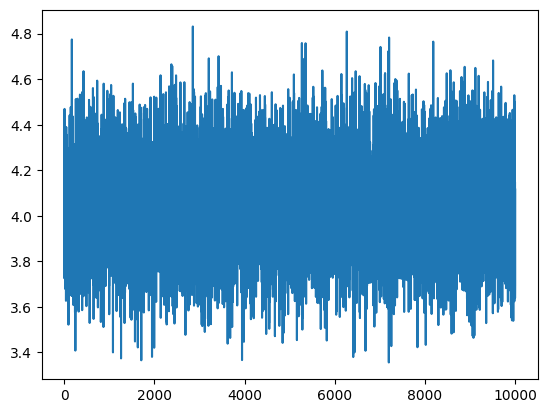

In [55]:
plt.plot(lossi)